In [33]:
import numpy as np
import numpy.testing as npt
from scipy.linalg import expm
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
from matplotlib.collections import PatchCollection
import scipy.spatial, scipy.linalg
import scipy.sparse.linalg
from scipy.misc import logsumexp
from scipy.cluster.hierarchy import linkage, dendrogram
import itertools as it
import time
%matplotlib inline


In [83]:
class svm_smo(): 
    
    def __init__(self, kernel,C):
        self.kernel = kernel
        self.c = C

    def getkernel(self, X, Y=None):
        n= len(X)
        n2 = n
        if(Y==None):
            X2=np.array(X)
            x2=len(X2)
            n2 = n
        else: 
            X2 = Y
            n2 = len(X2)
 
        if((self.kernel =='gaussian') or (self.kernel ==['gaussian'])):
            w = self.kp
            X1 = (X**2).sum(1).reshape(n,1)*np.ones((n,n2))
            U1 = (X2**2).sum(1).reshape(1,n2) * np.ones([n,n2])
            D = X1 - 2*(X.dot(X2.T)) + U1
            K = np.exp(-D/(2*w**2))
        elif((self.kernel =='polynomial') or (self.kernel ==['polynomial'])):
            p= self.kp
            K = (np.dot(X,X2.T)+1)**p
        elif((self.kernel =='linear') or (self.kernel ==['linear'])):
            K = np.dot(X,X2.T)
        else:
            raise AssertionError("Choose from ['gaussian','polynomial','linear']")
        return K
    
    
    def fx(self,X1,X2,Y):
        K=self.getkernel(X1,X2)
        alpY = (Y*self.alpha).reshape(len(self.alpha),1)
        return np.dot(K,alpY)-self.b#np.sign(np.dot(K,alpY)+self.b)
    
    def _compute_box_constraints(self, i, j, Y, alpha, C):
        
        if(Y[i]==Y[j]):
            L = np.max([0,alpha[i]+alpha[j]-C])
            H = np.min([C,alpha[i]+alpha[j]])
        else:
            L = np.max([0,alpha[j]-alpha[i]])
            H = np.min([C,C+alpha[j]-alpha[i]])
        return L, H 
    
    
    def _update_parameters(self, E_i, E_j, i, j, K, Y, alpha, b, C):
        L, H = self._compute_box_constraints( i, j, Y, alpha, C)
        if(L==H):
            return alpha, b, 0
        kappa = 2*K[i,j] -K[i,i] -K[j,j]
        if(kappa>=0):
            return alpha, b, 0
        
        aph2_new= alpha[j]-Y[j]*(E_i-E_j)/kappa
        
        if(aph2_new>H):
            aph2_new=H
        if(aph2_new<L):
            aph2_new=L
           
        aph1_new = alpha[i]+Y[i]*Y[j]*(alpha[j]-aph2_new)
        if(np.abs(alpha[j]-aph2_new)<0.0005):
            return alpha, b, 0
        
        alpha_new = np.array(alpha)
        alpha_new[i]= aph1_new
        alpha_new[j]= aph2_new
        
        new_b = self._compute_updated_b( E_i, E_j, i, j, K, Y, alpha, alpha_new, b, C)
            
        return alpha_new, new_b, 1
    
    
    def _compute_updated_b(self, E_i, E_j, i, j, K, Y, alpha_old, alpha_new, b_old, C):
        b1 = b_old+E_i+Y[i]*(alpha_new[i]-alpha_old[i])*K[i,i]+Y[j]*(alpha_new[j]-alpha_old[j])*K[i,j]
        b2 = b_old+E_j+Y[i]*(alpha_new[i]-alpha_old[i])*K[i,j]+Y[j]*(alpha_new[j]-alpha_old[j])*K[j,j]
        new_b=(b1+b2)/2
        
        if((alpha_new[i]>0)and(alpha_new[i]<C)):
            new_b = b1
        if((alpha_new[j]>0)and(alpha_new[j]<C)):
            new_b = b2
        
        return new_b
     
        
    def fit(self, X, Y):
        #self.X_fit = X
        N= len(X)
        rang=np.arange(N)
        K = self.getkernel(X)
        self.alpha = np.zeros(N)
        self.b = 0
        P=1000
        tol = 0.03
        p=0
        
        while(p<P):
            a=0
            for i in range(N):
                Ei = self.fx(X[i].reshape(1,len(X[i])),X,Y)-Y[i]
                if (((Y[i]*Ei < -tol) and (self.alpha[i] < self.c)) or ( (Y[i]*Ei > tol) and (self.alpha[i] > 0))):
                    j=np.random.choice(np.setdiff1d(rang, np.array([i])),1)[0]
                    Ej = self.fx(X[j].reshape(1,len(X[i])),X,Y)-Y[j]
                    self.alpha, self.b, updated=self._update_parameters( Ei[0,0], Ej[0,0], i, j, K, Y, self.alpha, self.b, self.c)
                    a = a+updated
                
            if(a==0):        
                p=p+1
            else:
                p=0
        
        f=self.fx(X,X,Y)*Y.reshape(len(Y),1)
        self.SV= X[np.where(np.abs(f[:,0]-1)<0.0001)[0]]#0.0001
        self.y = Y[np.where(np.abs(f[:,0]-1)<0.0001)[0]]
        self.alpha = self.alpha[np.where(np.abs(f[:,0]-1)<0.0001)[0]]
        
    def predict(self, X):
        return np.sign(self.fx(X,self.SV,self.y)[:,0])

In [84]:
def plot_svm_2d(X, y, model):
    n=len(X)
    plt.figure(figsize = (6, 6))
    plt.plot(X[y ==  1,0], X[y ==  1,1], 'ro')
    plt.plot(X[y == -1,0], X[y == -1,1], 'bo')
    plt.plot(model.SV[:,0],model.SV[:,1],'kx')
    a = np.linspace(np.min(X[:,0])-1, np.max(X[:,0])+1, n)
    b = np.linspace(np.min(X[:,1])-1, np.max(X[:,1])+1, n)
    A, B = np.meshgrid(a,b)
    mesh_z = np.zeros((n, n))
    for y in range(n):
        for x in range(n):
            mesh_z[y, x] = model.fx(np.array([a[x], b[y]]).reshape(1,2),C.SV,C.y)
    plt.contour(A, B, mesh_z, 0)

In [85]:

np.random.seed(1)
X_tr = np.hstack((np.random.normal(size=[2, 30]), np.random.normal(size=[2, 30]) + np.array([2., 2.])[:, np.newaxis])).T
Y_tr = np.array([1] * 30 + [-1] * 30)
X_te = np.hstack((np.random.normal(size=[2, 30]), np.random.normal(size=[2, 30]) + np.array([2., 2.])[:, np.newaxis])).T
Y_te = np.array([1] * 30 + [-1] * 30)
C = svm_smo(kernel='linear', C=1.)
C.fit(X=X_tr, Y=Y_tr)
Y_pred = C.predict(X_te)
loss = float(np.sum(np.sign(Y_te) != np.sign(Y_pred)))/float(len(Y_te))
print('test case loss', loss)

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:10: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


test case loss 0.21666666666666667


In [86]:
Y_pred

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1., -1., -1.,  1.,  1., -1., -1., -1.,
        1., -1., -1., -1., -1., -1.,  1., -1., -1., -1., -1.,  1., -1.,
        1., -1.,  1.,  1.,  1.,  1.,  1., -1.])

In [87]:
np.sign(Y_te)

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [88]:
C.SV

array([[ 2.37756379,  0.38422765]])

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:10: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


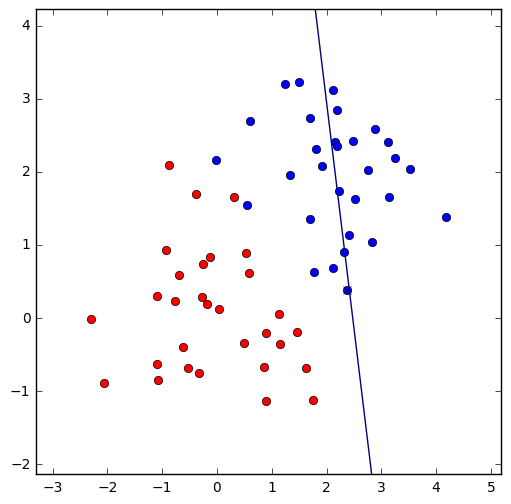

In [89]:
plot_svm_2d(X_tr, Y_tr, C)

In [60]:
a = np.linspace(-3,3,90)
b = np.linspace(-3,3,90)
A, B = np.meshgrid(x,y)
Z = [[a,b] for (a,b) in zip(A,B)]
Z = [C.fx(np.append(a.reshape(len(a),1),b.reshape(len(b),1),1),C.SV,C.y).T for (a,b) in zip(A,B)]

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:10: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [61]:
print(X)
print(Y)

[[-3.         -2.93258427 -2.86516854 ...,  2.86516854  2.93258427  3.        ]
 [-3.         -2.93258427 -2.86516854 ...,  2.86516854  2.93258427  3.        ]
 [-3.         -2.93258427 -2.86516854 ...,  2.86516854  2.93258427  3.        ]
 ..., 
 [-3.         -2.93258427 -2.86516854 ...,  2.86516854  2.93258427  3.        ]
 [-3.         -2.93258427 -2.86516854 ...,  2.86516854  2.93258427  3.        ]
 [-3.         -2.93258427 -2.86516854 ...,  2.86516854  2.93258427  3.        ]]
[[-3.         -3.         -3.         ..., -3.         -3.         -3.        ]
 [-2.93258427 -2.93258427 -2.93258427 ..., -2.93258427 -2.93258427
  -2.93258427]
 [-2.86516854 -2.86516854 -2.86516854 ..., -2.86516854 -2.86516854
  -2.86516854]
 ..., 
 [ 2.86516854  2.86516854  2.86516854 ...,  2.86516854  2.86516854
   2.86516854]
 [ 2.93258427  2.93258427  2.93258427 ...,  2.93258427  2.93258427
   2.93258427]
 [ 3.          3.          3.         ...,  3.          3.          3.        ]]


In [62]:
Z[0]

array([[ 6.47546081,  6.4022495 ,  6.32903819,  6.25582688,  6.18261557,
         6.10940426,  6.03619295,  5.96298164,  5.88977033,  5.81655902,
         5.74334771,  5.67013641,  5.5969251 ,  5.52371379,  5.45050248,
         5.37729117,  5.30407986,  5.23086855,  5.15765724,  5.08444593,
         5.01123462,  4.93802331,  4.864812  ,  4.79160069,  4.71838938,
         4.64517807,  4.57196676,  4.49875545,  4.42554415,  4.35233284,
         4.27912153,  4.20591022,  4.13269891,  4.0594876 ,  3.98627629,
         3.91306498,  3.83985367,  3.76664236,  3.69343105,  3.62021974,
         3.54700843,  3.47379712,  3.40058581,  3.3273745 ,  3.2541632 ,
         3.18095189,  3.10774058,  3.03452927,  2.96131796,  2.88810665,
         2.81489534,  2.74168403,  2.66847272,  2.59526141,  2.5220501 ,
         2.44883879,  2.37562748,  2.30241617,  2.22920486,  2.15599355,
         2.08278224,  2.00957094,  1.93635963,  1.86314832,  1.78993701,
         1.7167257 ,  1.64351439,  1.57030308,  1.4

In [51]:
C.SV.shape

(1, 2)

In [50]:
C.alpha

array([ 0.45675652])